In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.0001
# train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure", 0.2, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_2", 0.2, 10)

Found 900 files belonging to 2 classes.
Using 720 files for training.
Using 180 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (10, 4000)
Example label shape: (10,)


2024-03-31 15:45:48.689805: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-31 15:45:48.689827: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-31 15:45:48.689834: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-31 15:45:48.689878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 15:45:48.689897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [2]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

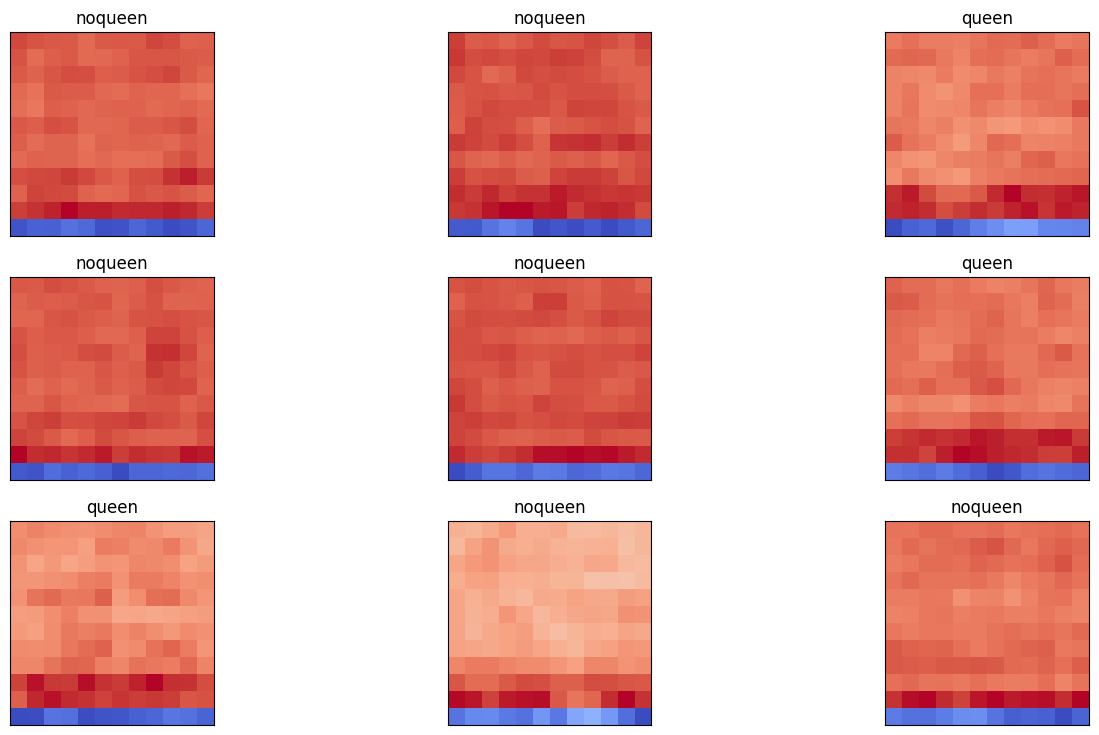

In [3]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [5]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

2024-03-31 15:45:50.150873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-31 15:45:51.035493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


72/72 [==============================] - 1s 13ms/step - loss: 0.6050 - accuracy: 0.6653 - val_loss: 0.4788 - val_accuracy: 0.7111
Epoch 2/20
72/72 [==============================] - 1s 10ms/step - loss: 0.4183 - accuracy: 0.8319 - val_loss: 0.2912 - val_accuracy: 0.9111
Epoch 3/20
72/72 [==============================] - 1s 9ms/step - loss: 0.3219 - accuracy: 0.9014 - val_loss: 0.2332 - val_accuracy: 0.9222
Epoch 4/20
72/72 [==============================] - 1s 10ms/step - loss: 0.2757 - accuracy: 0.9139 - val_loss: 0.2160 - val_accuracy: 0.9167
Epoch 5/20
72/72 [==============================] - 1s 10ms/step - loss: 0.2481 - accuracy: 0.9319 - val_loss: 0.2193 - val_accuracy: 0.9056
Epoch 6/20
72/72 [==============================] - 1s 9ms/step - loss: 0.2206 - accuracy: 0.9347 - val_loss: 0.2283 - val_accuracy: 0.9056


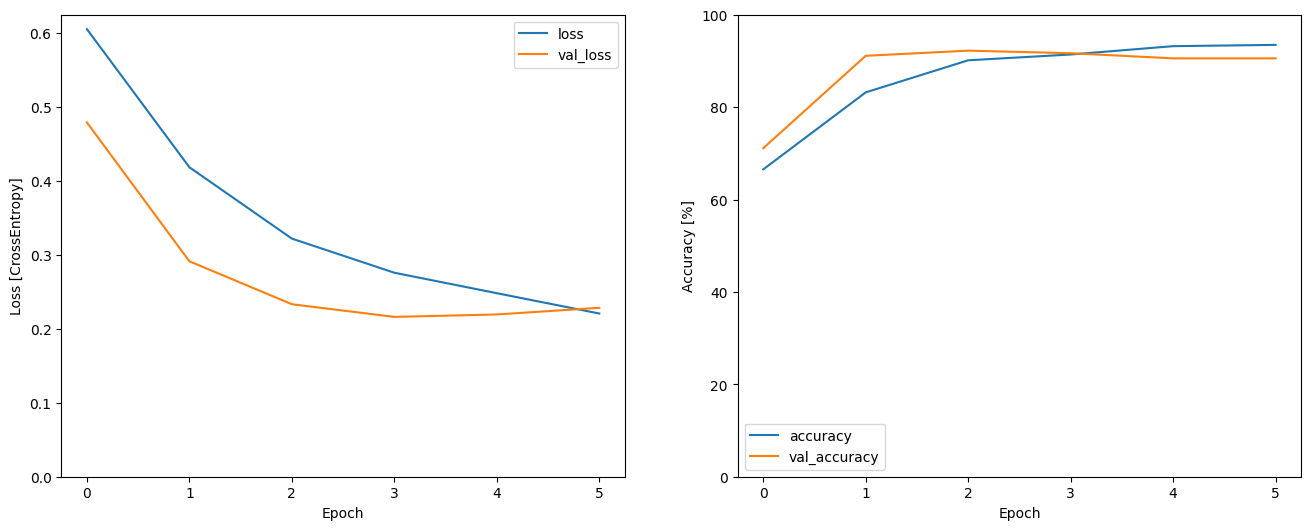

In [6]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
72/72 [==============================] - 1s 6ms/step - loss: 0.6165 - accuracy: 0.6611 - val_loss: 0.5285 - val_accuracy: 0.8167
Epoch 2/20
72/72 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.8083 - val_loss: 0.4294 - val_accuracy: 0.8389
Epoch 3/20
72/72 [==============================] - 0s 5ms/step - loss: 0.4267 - accuracy: 0.8694 - val_loss: 0.3557 - val_accuracy: 0.9111
Epoch 4/20
72/72 [==============================] - 0s 5ms/step - loss: 0.3688 - accuracy: 0.8944 - val_loss: 0.3032 - val_accuracy: 0.9111
Epoch 5/20
72/72 [==============================] - 0s 5ms/step - loss: 0.3314 - accuracy: 0.9069 - val_loss: 0.2845 - val_accuracy: 0.8944
Epoch 6/20
72/72 [==============================] - 0s 5ms/step - loss: 0.3021 - accuracy: 0.9125 - val_loss: 0.2652 - val_accuracy: 0.9000


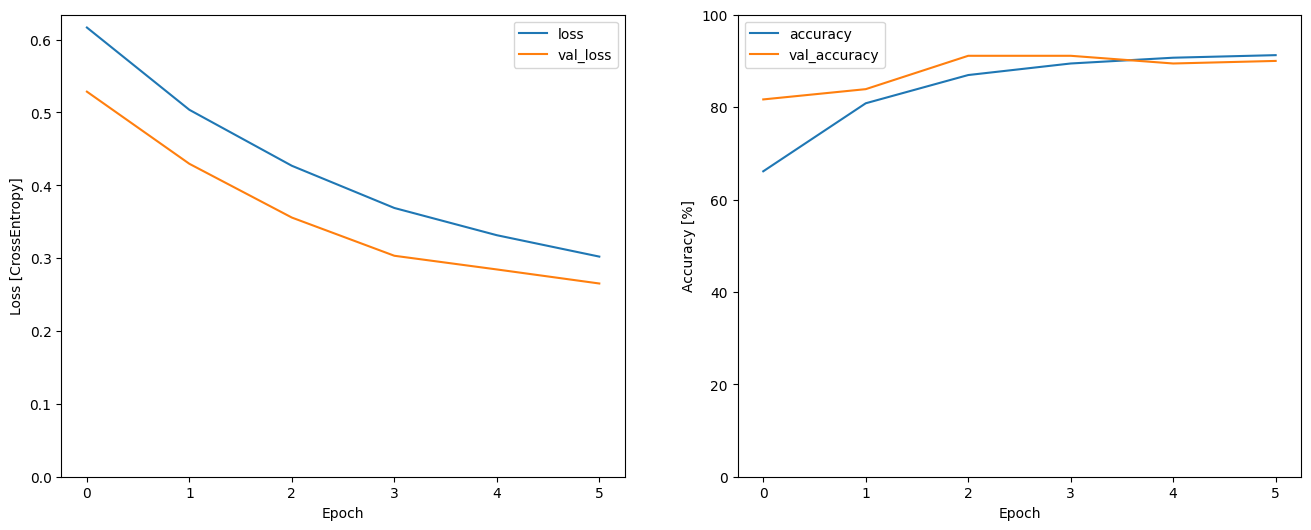

In [7]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


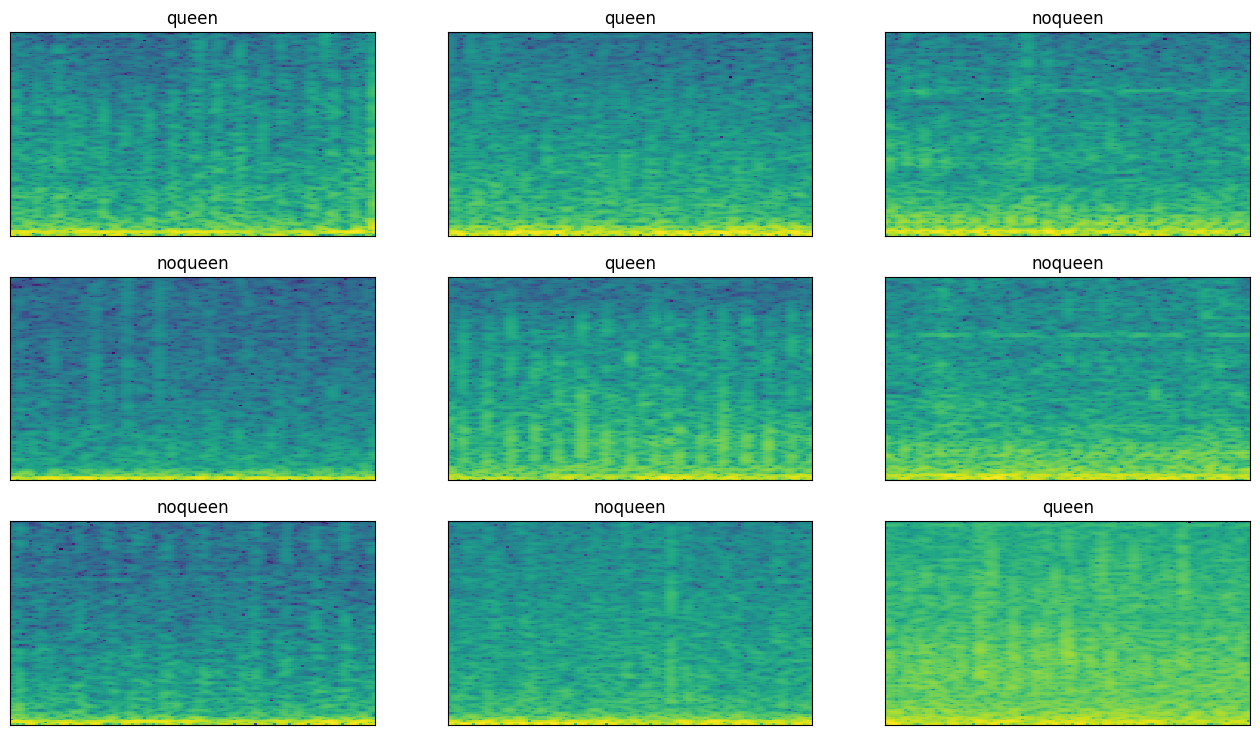

In [8]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [9]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/20
72/72 [==============================] - 1s 12ms/step - loss: 0.6518 - accuracy: 0.6167 - val_loss: 0.6045 - val_accuracy: 0.6389
Epoch 2/20
72/72 [==============================] - 1s 9ms/step - loss: 0.5938 - accuracy: 0.6306 - val_loss: 0.5708 - val_accuracy: 0.6444
Epoch 3/20
72/72 [==============================] - 1s 10ms/step - loss: 0.5270 - accuracy: 0.7139 - val_loss: 0.5798 - val_accuracy: 0.6500
Epoch 4/20
72/72 [==============================] - 1s 9ms/step - loss: 0.4550 - accuracy: 0.7847 - val_loss: 0.4711 - val_accuracy: 0.7222
Epoch 5/20
72/72 [==============================] - 1s 9ms/step - loss: 0.3864 - accuracy: 0.8250 - val_loss: 0.3519 - val_accuracy: 0.8444
Epoch 6/20
72/72 [==============================] - 1s 9ms/step - loss: 0.3333 - accuracy: 0.8639 - val_loss: 0.3208 - val_accuracy: 0.8500
Epoch 7/20
72/72 [==============================] - 1s 9ms/step - loss: 0.3049 - accuracy: 0.8722 - val_loss: 0.2660 - val_accuracy: 0.9278
Epoch 8/20
72/72 [

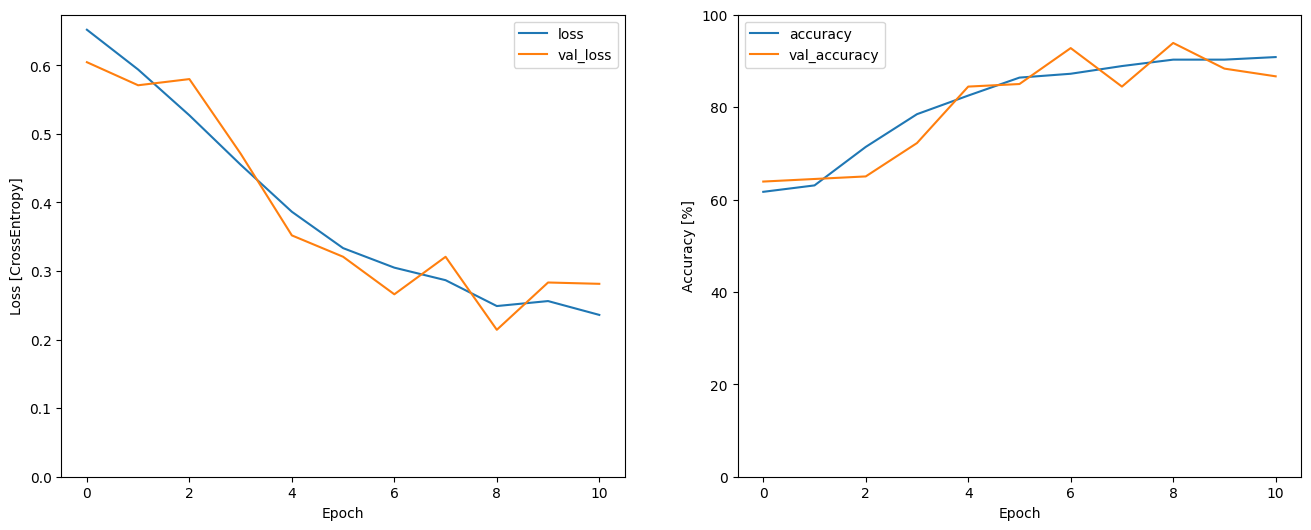

In [10]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/20
72/72 [==============================] - 1s 10ms/step - loss: 0.6340 - accuracy: 0.6208 - val_loss: 0.5689 - val_accuracy: 0.6556
Epoch 2/20
72/72 [==============================] - 1s 8ms/step - loss: 0.5397 - accuracy: 0.6972 - val_loss: 0.4830 - val_accuracy: 0.6944
Epoch 3/20
72/72 [==============================] - 1s 8ms/step - loss: 0.4500 - accuracy: 0.7764 - val_loss: 0.3810 - val_accuracy: 0.8722
Epoch 4/20
72/72 [==============================] - 1s 8ms/step - loss: 0.3970 - accuracy: 0.8236 - val_loss: 0.3330 - val_accuracy: 0.8889
Epoch 5/20
72/72 [==============================] - 1s 8ms/step - loss: 0.3522 - accuracy: 0.8556 - val_loss: 0.3138 - val_accuracy: 0.8778
Epoch 6/20
72/72 [==============================] - 1s 8ms/step - loss: 0.3167 - accuracy: 0.8833 - val_loss: 0.2568 - val_accuracy: 0.9333
Epoch 7/20
72/72 [==============================] - 1s 8ms/step - loss: 0.2902 - accuracy: 0.9083 - val_loss: 0.2315 - val_accuracy: 0.9278
Epoch 8/20
72/72 [=

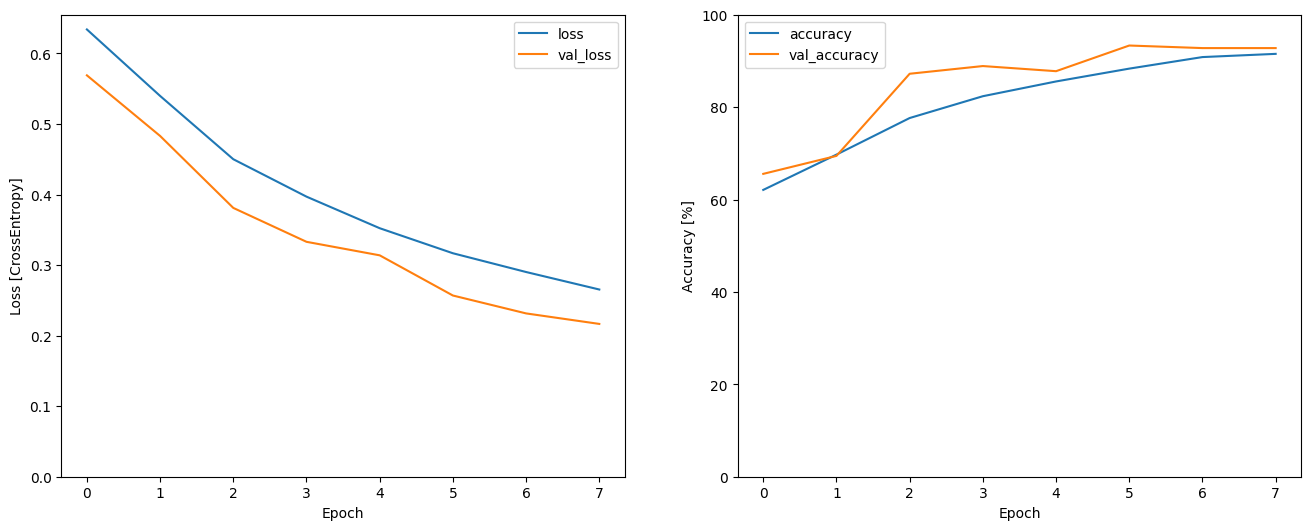

In [11]:
model_spec_conv = get_conv_model_mini(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [12]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
history_spec_conv

# Summary

In [14]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, Val. Loss: {history.history['val_loss'][-1]:.2f}, Val. Acc: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("MFCCs + Sequential model       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv model             ", history_mfcc_conv)
history_to_summary("Spectrogram + Sequential model ", history_spec_seq)
history_to_summary("Spectrogram + Conv model       ", history_spec_conv)


MFCCs + Sequential model       :    Loss: 0.22, Acc: 0.93, Val. Loss: 0.23, Val. Acc: 0.91
MFCCs + Conv model             :    Loss: 0.30, Acc: 0.91, Val. Loss: 0.27, Val. Acc: 0.90
Spectrogram + Sequential model :    Loss: 0.24, Acc: 0.91, Val. Loss: 0.28, Val. Acc: 0.87
Spectrogram + Conv model       :    Loss: 0.27, Acc: 0.92, Val. Loss: 0.22, Val. Acc: 0.93
